## FC for Widespread Pain Subjects
#### Input: *stc.mat
####  Output: con, visualization

In [1]:
import os
from pathlib import Path
import sys
import mne 
import numpy as np
from mne.datasets import fetch_fsaverage
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
sys.path.append("/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/")
from eeg_toolkit import preprocess, utils
import eeg_toolkit.functional_connectivity as fc

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


### Paths

In [2]:
# sl_method = input("Source Localization Method (1- MNE or 2- dSPM): ")
# sl_method = 'MNE' if sl_method == '1' else 'dSPM'
sl_method = 'dSPM'

In [3]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / f"Source Time Courses ({sl_method})"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
fc_path = data_dir / f"Functional Connectivity ({sl_method})"
fc_subset_path = fc_path / subset
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Get subset of subjects with and without widespread pain

In [4]:
# viable subjects
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP_WSP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

# CP Subs with widespread pain
widespread_pain_CP = [
    '055',
    '052',
    '046',
    '039',
    '036',
    '031',
    '022',
    '045',
    '040',
    '034',
    '032',
    '024',
    '018'
]

# Sort and limit CP subs to only those with widespread pain
widespread_pain_CP.sort()
sub_ids_CP_WSP = widespread_pain_CP

# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

# Combine selected CP and HC subjects
sub_ids = sub_ids_CP_WSP + sub_ids_HC

# These subjects have no keypresses and thus no resting timestamps, but they do have epoched data
NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids = [sub for sub in sub_ids if sub not in NO_KEYPRESS]

In [5]:
sub_ids_CP_WSP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

print(f"Chronics: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Controls: {len(sub_ids_HC)}")
print([el for el in sub_ids_HC])
print(f"Total: {len(sub_ids)}")

Chronics: 12
['018', '022', '024', '031', '032', '034', '036', '039', '040', '046', '052', '055']
Controls: 19
['C2.', 'C3.', 'C6.', 'C7.', 'C9.', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C24', 'C25', 'C26', 'C27']
Total: 31


In [6]:
# Chronic Pain Subs without widespread pain
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP_No_WSP = [el for el in sub_ids if el.startswith('0')]

# Exclude temporarily missing keypresses
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in NO_KEYPRESS]

# Final list of CP subs with localized pain
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in sub_ids_CP_WSP]

# Exclude subjects with low trial count
# TODO: figure out how to skip
# 055 has 4 Hand 256mN trials (WSP)
# sub_ids_CP_WSP.remove('055') 
# 036 has 6; 037 has 6, 044 has 5, 056 has 5, 058 has 4 (Localized pain)
# sub_ids_CP_No_WSP.remove(['036', '037', '044', '056', '058'])

print(f"Chronics with widespread pain: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Chronics without widespread pain: {len(sub_ids_CP_No_WSP)}")
print([sub for sub in sub_ids_CP_No_WSP])


Chronics with widespread pain: 12
['018', '022', '024', '031', '032', '034', '036', '039', '040', '046', '052', '055']
Chronics without widespread pain: 23
['020', '021', '023', '027', '029', '030', '033', '035', '037', '038', '041', '042', '043', '044', '048', '049', '050', '051', '053', '054', '056', '057', '058']


### Settings for conditions/bands/methods

In [7]:
# Settings
sfreq = 400  # Hz
tmin, tmax = 0.0, 1.25  # exclude the baseline period for connectivity estimation

# Use canonical bands or narrower bands
narrow_bands = True    

# Choose which connectivity estimates to run. "amplitude", "phase", or "both"
method_choice = "both"

# Include intermediate stimulus?
include_LS = False

# Save group data?
save_group_data_flag = False

# Load group data instead
load_group_data_flag = False

# Evoked only or include resting too?
include_resting = False

### Define ROIs, frequency bands, conditions, and methods for FC

In [8]:
####################################################################
# REGIONS OF INTEREST
roi_names = [  # Left
    "rostralanteriorcingulate-lh",  # Left Rostral ACC
    "caudalanteriorcingulate-lh",  # Left Caudal ACC
    "postcentral-lh",  # Left S1,
    "insula-lh",
    "superiorfrontal-lh",  # Left Insula, Left DL-PFC,
    "medialorbitofrontal-lh",  # Left Medial-OFC
    # Right
    "rostralanteriorcingulate-rh",  # Right Rostral ACC
    "caudalanteriorcingulate-rh",  # Right Caudal ACC
    "postcentral-rh",  # , Right S1
    "insula-rh",
    "superiorfrontal-rh",  # Right Insula, Right DL-PFC
    "medialorbitofrontal-rh",
]  # Right Medial-OFC

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "ACC-lh", "S1-lh", "insula-lh", "dlPFC-lh", "mOFC-lh",
                "rACC-rh", "ACC-rh", "S1-rh", "insula-rh", "dlPFC-rh", "mOFC-rh"]


####################################################################
# BANDS OF INTEREST
if not narrow_bands:
    Freq_Bands = {
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        "alpha": [8.0, 13.0],
        "beta": [13.0, 30.0],
        "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        "high-gamma": [61.5, 100.0],
    }
else:
    Freq_Bands = { # Narrower bands and overlaps
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        # "low-alpha": [6.0, 12.0],
        # "high-alpha": [10.0, 15.0],
        # "low-beta": [12.0, 22.0],
        # "high-beta": [20.0, 32.0],
        # "low-gamma-i": [28.0, 46.0],
        # "low-gamma-ii": [44.0, 58.5],
        # # "notch": [58.5, 61.5],
        # "high-gamma-i": [61.5, 82.0],
        # "high-gamma-ii": [80.0, 100.0],
    }
band_names = [band for band in Freq_Bands]

####################################################################
# CONNECTIVITY METHODS
if method_choice == "phase":
    con_methods = ["wpli2_debiased"]
elif method_choice == "amplitude":
    con_methods = [ "aec_pairwise",
                   "aec_symmetric"]
elif method_choice == "both":
    con_methods = [
    "wpli2_debiased",
    #   "dpli",
    "aec_pairwise",
    "aec_symmetric", # keep only symmetric for now
    ]
    
####################################################################
# CONDITIONS
conditions = (
    [
        "Hand 32 mN",
        "Hand 128 mN",
        "Hand 256 mN",
        "Back 32 mN",
        "Back 128 mN",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        # "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        # "Eyes Open", # TODO: uncomment
        # "Eyes Closed",
    ]
)

# Choose to exclude resting state data
conditions = conditions if include_resting else [
    c for c in conditions if "Eyes" not in c
]

####################################################################
# CONDITION DICTIONARY
condition_dict = {
        "Hand 32 mN": 0,
        'Hand LS': 1,
        "Hand 256 mN": 2,
        "Back 32 mN": 3,
        'Back LS': 4,
        "Back 256 mN": 5,
        "Eyes Open": 6,
        "Eyes Closed": 7,
}

####################################################################
# GROUP NAMES
groups=['Chronic Pain with Widespread Pain','Chronic Pain', 'Healthy Control']

### Compute functional connectivity for each subject in each group

In [9]:
# CLBP with WSP
if not load_group_data_flag:
    sub_con_CP_WSP = {}
    for sub_id in sub_ids_CP_WSP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain w/ WSP",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_CP_WSP[sub_id] = sub_avg_cons
        
    utils.clear_display()

018
Reading stimulus labels and pain ratings for Subject 018...

*stim_labels length = 73*
*pain_ratings_raw length = 73*

+----------------+----------------+
| Subject        | 018            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/Source Time Courses (dSPM)/zscored_Epochs/5_sec_time_window/022_epochs.pkl'

In [ ]:
# Healthy Control group
if not load_group_data_flag:
    sub_con_HC = {}
    for sub_id in sub_ids_HC:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Healthy Control",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_HC[sub_id] = sub_avg_cons
    utils.clear_display()

In [ ]:
# CLBP without WSP
if not load_group_data_flag:
    sub_con_CP_No_WSP = {}
    for sub_id in sub_ids_CP_No_WSP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain w/ Localized Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_CP_No_WSP[sub_id] = sub_avg_cons
        
    utils.clear_display()

In [ ]:
if not load_group_data_flag:
    # Stack the connectivity of all subjects in each group
    group_con_CP_WSP = fc.compute_group_con(sub_con_CP_WSP, conditions, con_methods, band_names)
    group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)
    group_con_CP_No_WSP = fc.compute_group_con(sub_con_CP_No_WSP, conditions, con_methods, band_names)
else:
    group_con_CP_WSP = utils.unpickle_data(save_path, f"group_con_{subset}_CP_WSP.pkl")
    group_con_HC = utils.unpickle_data(save_path, f"group_con_{subset}_HC.pkl")
    group_con_CP_No_WSP = utils.unpickle_data(save_path, f"group_con_{subset}_CP_No_WSP.pkl")

In [ ]:
if save_group_data_flag:
    # Save/checkpoint as pickle
    utils.pickle_data(save_path, f"sub_con_{subset}_CP_WSP.pkl", sub_con_CP_WSP)
    utils.pickle_data(save_path, f"group_con_{subset}_CP_WSP.pkl", group_con_CP_WSP)

    utils.pickle_data(save_path, f"sub_con_{subset}_CP_No_WSP.pkl", sub_con_CP_No_WSP)
    utils.pickle_data(save_path, f"group_con_{subset}_CP_No_WSP.pkl", group_con_CP_No_WSP)
    
    utils.pickle_data(save_path, f"sub_con_{subset}_HC.pkl", sub_con_HC)
    utils.pickle_data(save_path, f"group_con_{subset}_HC.pkl", group_con_HC)

### Plot settings

In [14]:
# Highlight p-values with red box automatically
highlight_pvals=False

# Make any non-significant squares white
show_only_significant=True

# Set a minimum value for the functional connectivity (for sub zero values)
min_fc_val=None

# Set title automatically
set_title=True

# Show values in the matrix quadrants
show_fc_vals=True

# Round negative values to zero
round_neg_vals=True

# Plot 3D brain visualization
plot_brain=True

### Plot and compute satistics to assess statistical differences 

In [ ]:
# CP Widespread Pain Hand HS. vs CP without Widespread Pain
these_group_names = ["CP w/ Widespread Pain", "CP with Localized Pain","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP_WSP, group_con_CP_No_WSP]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_CP_No_WSP_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
            group1_stack = these_group_cons[0][condition][method][band]
            group2_stack = these_group_cons[1][condition][method][band]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            print(f"Num epochs: {nepochs_1} vs. {nepochs_2}")
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_names,
                roi_acronyms=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=["CP w/ WSP vs. CP w/o WSP",
                        these_group_names[0], 
                        these_group_names[1], ],
                save_names=[these_group_names[0], 
                            these_group_names[1],
                            "Mann_Whitney_U_test"],
                save_path=stats_save_path,
                )
            
            fc.plot_connectivity_and_stats(means_1,
                                           means_2,
                                           sem_1,
                                           sem_2,
                                           p_values,
                                           **plot_kwargs,
                                           save_fig=True,
                                           highlight_pvals=highlight_pvals,
                                           min_fc_val=min_fc_val,
                                           set_title=set_title,
                                           show_fc_vals=show_fc_vals,
                                           round_neg_vals=round_neg_vals,
            )

            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path, f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )

In [ ]:
# CP Widespread Pain Hand HS. vs Healthy Control Hand HS
these_group_names = ["CP w/ Widespread Pain", "Healthy Control","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP_WSP, group_con_HC]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_HC_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
            group1_stack = these_group_cons[0][condition][method][band]
            group2_stack = these_group_cons[1][condition][method][band]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            print(f"Num epochs: {nepochs_1} vs. {nepochs_2}")

            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_names,
                roi_acronyms=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=["CP with WSP vs. HC",
                        these_group_names[0], 
                        these_group_names[1],],
                save_names=[these_group_names[0], 
                            these_group_names[1],
                            "Mann_Whitney_U_test"],
                save_path=stats_save_path,
                )           
            
            fc.plot_connectivity_and_stats(means_1,
                                           means_2,
                                           sem_1,
                                           sem_2,
                                           p_values,
                                           **plot_kwargs,
                                           save_fig=True,
                                           highlight_pvals=highlight_pvals,
                                           min_fc_val=min_fc_val,
                                           set_title=set_title,
                                           show_fc_vals=show_fc_vals,
                                           round_neg_vals=round_neg_vals,
            )
            
            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse1
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path, f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )

## Plot individual data in each group

### Plot settings

In [15]:
# Highlight p-values with red box automatically
highlight_pvals=False

# Make any non-significant squares white
show_only_significant=True

# Set a minimum value for the functional connectivity (for sub zero values)
min_fc_val=None

# Set title automatically
set_title=True

# Show values in the matrix quadrants
show_fc_vals=True

# Round negative values to zero
round_neg_vals=True

# Plot 3D brain visualization
plot_brain=True

In [16]:
# TODO: temporary
sub_ids_CP_WSP = ['018']

In [17]:
# CLBP with WSP
sub_con_CP_WSP = {}
for sub_id in sub_ids_CP_WSP:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Chronic Pain w/ WSP",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        condition_dict,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_CP_WSP[sub_id] = sub_avg_cons
    
utils.clear_display()

018
Reading stimulus labels and pain ratings for Subject 018...

*stim_labels length = 73*
*pain_ratings_raw length = 73*

+----------------+----------------+
| Subject        | 018            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

ts shape = (12, 500)
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

ts shape = (12, 500)
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

ts shape = (12, 500)
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

ts shape = (12, 500)
Setting up ba

Hand 256 mN - 018 - ['CP w/ Widespread Pain'] - wpli2_debiased - theta
Num epochs: 20
+-------------------------+---------+----------------+----------------+
|        ROI Pair         | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-------------------------+---------+----------------+----------------+
|    S1-lh <-> rACC-lh    | -0.072  |  -0.072 ± 0.0  |  -0.072 ± 0.0  |
|    S1-lh <-> ACC-lh     |  -0.09  |  -0.09 ± 0.0   |  -0.09 ± 0.0   |
|  insula-lh <-> rACC-lh  |  -0.07  |  -0.07 ± 0.0   |  -0.07 ± 0.0   |
|  insula-lh <-> ACC-lh   |  -0.02  |  -0.02 ± 0.0   |  -0.02 ± 0.0   |
|   insula-lh <-> S1-lh   | -0.076  |  -0.076 ± 0.0  |  -0.076 ± 0.0  |
|   dlPFC-lh <-> S1-lh    | -0.084  |  -0.084 ± 0.0  |  -0.084 ± 0.0  |
| dlPFC-lh <-> insula-lh  | -0.052  |  -0.052 ± 0.0  |  -0.052 ± 0.0  |
|    mOFC-lh <-> S1-lh    | -0.068  |  -0.068 ± 0.0  |  -0.068 ± 0.0  |
|  mOFC-lh <-> insula-lh  | -0.068  |  -0.068 ± 0.0  |  -0.068 ± 0.0  |
|   rACC-rh <-> ACC-lh    | -0.043  |  -0.043 ± 0.

IndexError: list assignment index out of range

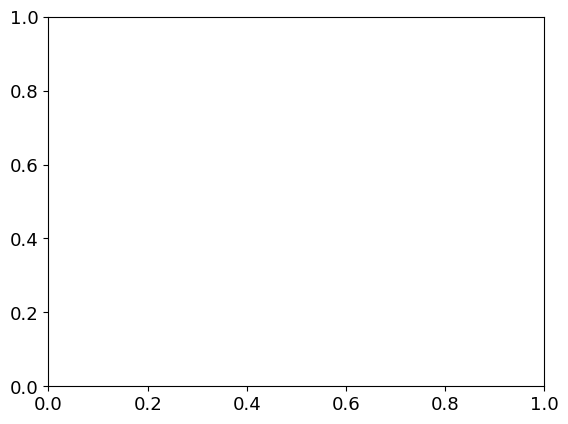

In [18]:
# CP Widespread Pain
this_group_names = ["CP w/ Widespread Pain"]
this_group_cons = sub_con_CP_WSP
n=len(roi_names)

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_individual_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)
    for sub_id in sub_ids_CP_WSP:
        for method in con_methods:
            for band in band_names:
                # Select groups for mann-whitney
                print(f"{condition} - {sub_id} - {this_group_names} - {method} - {band}")
                group1_stack = this_group_cons[sub_id][condition][method][band]
                nepochs_1 = this_group_cons[sub_id][condition]['num_epochs']
                print(f"Num epochs: {nepochs_1}")

                # Plotting
                # Gather the information for plotting
                plot_kwargs= dict(
                    method=method,
                    band=band, 
                    roi_names=roi_names,
                    roi_acronyms=roi_acronyms,
                    condition=condition,
                    group_names=this_group_names,
                    nepochs=[nepochs_1],
                    titles=[this_group_names[0],],
                    save_names=[this_group_names],
                    save_path=stats_save_path,
                    )
                
                fc.plot_connectivity_and_stats(
                    means_1=group1_stack,
                    means_2=group1_stack,
                    sem_1=np.zeros((n, n)),
                    sem_2=np.zeros((n, n)),
                    p_values=group1_stack,
                    **plot_kwargs,
                    save_fig=True,
                    highlight_pvals=highlight_pvals,
                    show_only_significant=show_only_significant,
                    min_fc_val=min_fc_val,
                    set_title=set_title,
                    show_fc_vals=show_fc_vals,
                    round_neg_vals=round_neg_vals,
                )

                if "aec" in method and plot_brain:
                    # Convert ROI names to labels
                    labels = [
                        mne.read_labels_from_annot(
                            subject, regexp=roi, subjects_dir=subjects_dir
                        )[0]
                        for roi in roi_names
                    ]

                    # Load the inverse
                    inv = None
                    if "Eyes" not in condition:
                        inv = utils.unpickle_data(
                            zscored_epochs_data_path / f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Open":
                        inv = utils.unpickle_data(
                            EO_resting_data_path / f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Closed":
                        inv = utils.unpickle_data(
                            EC_resting_data_path / f"{sub_id}_inv.pkl"
                        )

                    fc.plot_degree(
                        p_values, 
                        title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_1, 
                        title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_2, 
                        title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )